# Section 5.1 — Introduction to Bayesian statistics

This notebook contains the code examples from [Section 5.1 Introduction to Bayesian statistics]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayesian/intro"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

In [4]:
from ministats.utils import savefigure

## Definitions

## Bayesian inference

### Bayesian updating of posterior probabilities

Saved figure to figures/bayesian/intro/panel_coin_posteriors.pdf
Saved figure to figures/bayesian/intro/panel_coin_posteriors.png


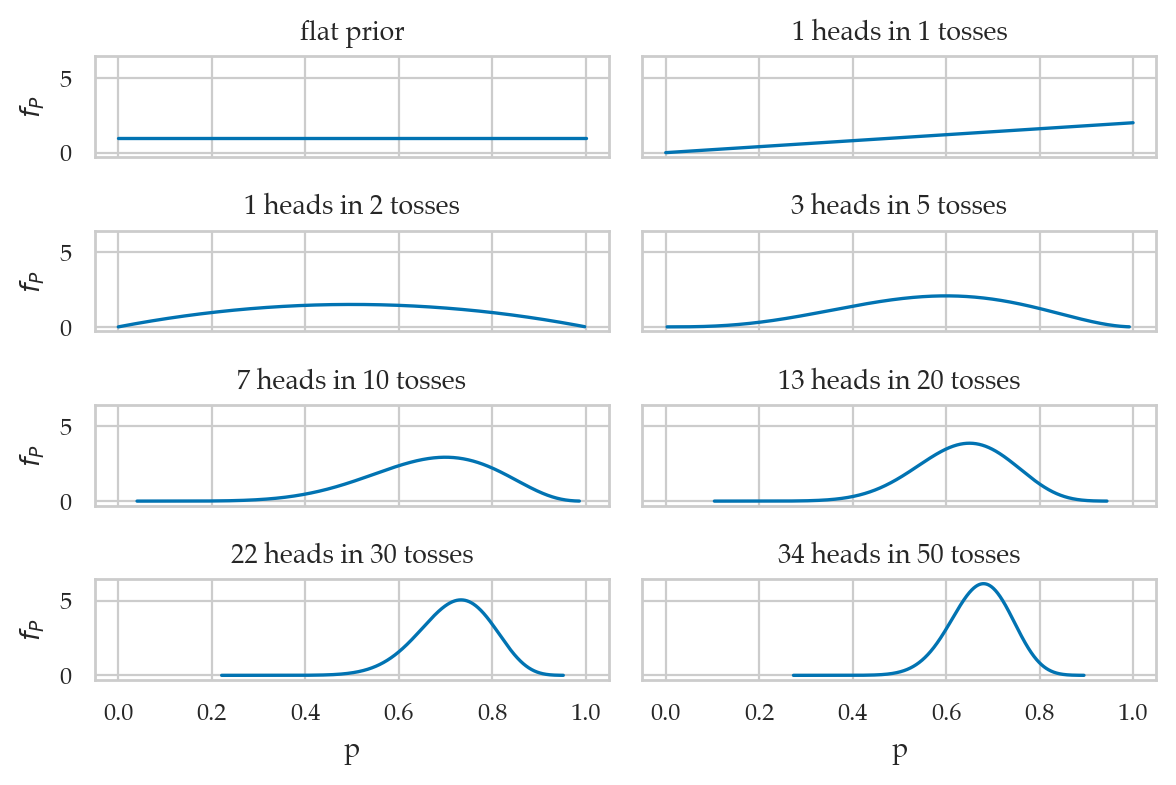

In [5]:
# FIGURES ONLY
from scipy.stats import bernoulli
from scipy.stats import beta
from ministats import plot_pdf

n_rows = 8
ns =       [0, 1, 2, 5, 10, 20, 30, 50]
outcomes = [0, 1, 1, 3,  7, 13, 22, 34]
# outcomes were generated from coin with true p = 0.7
assert len(outcomes) == n_rows
assert len(ns) == n_rows
n_rows = int(len(outcomes))

with plt.rc_context({"figure.figsize":(6,4)}):
    fig, axs_matrix = plt.subplots(n_rows//2, 2, sharex=True, sharey=True)
    axs = [ax for row in axs_matrix for ax in row]
    for i, ax in enumerate(axs):
        heads, n = outcomes[i], ns[i]
        rvPpost = beta(a=1+heads, b=1+n-heads)
        plot_pdf(rvPpost, rv_name="P", ax=ax)
        if i==0:
            ax.set_title("flat prior")
        else:
            ax.set_title(f"{heads} heads in {n} tosses")

    filename = os.path.join(DESTDIR, "panel_coin_posteriors.pdf")
    savefigure(fig, filename)

Saved figure to figures/bayesian/intro/ridgeplot_coin_posteriors.pdf
Saved figure to figures/bayesian/intro/ridgeplot_coin_posteriors.png


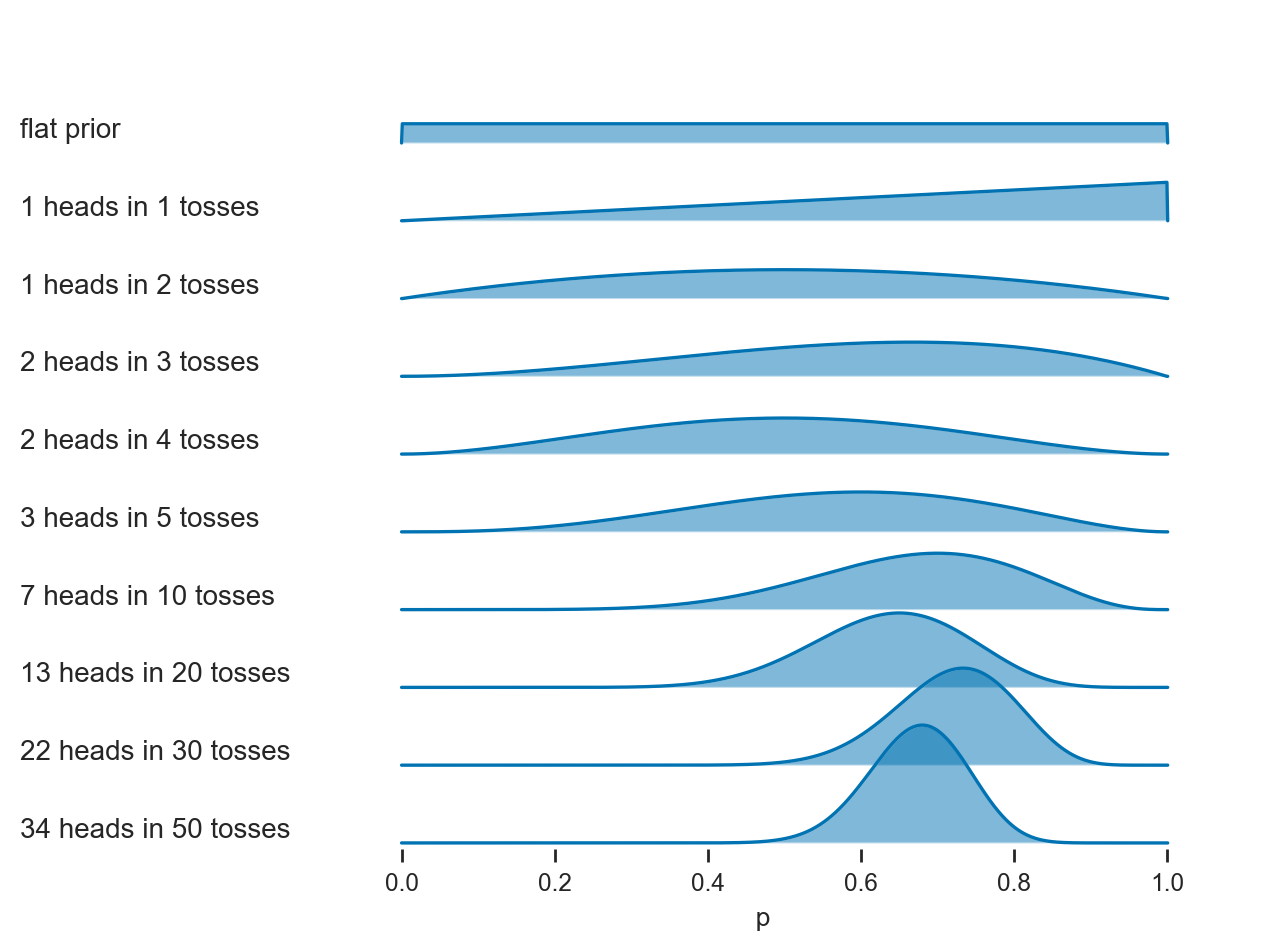

In [6]:
# FIGURES ONLY
# Inspired by  https://python-graph-gallery.com/ridgeline-graph-seaborn/

n_rows = 10
ns =       [0, 1, 2, 3, 4, 5, 10, 20, 30,  50]
outcomes = [0, 1, 1, 2, 2, 3,  7, 13, 22,  34]
# outcomes were generated from coin with true p = 0.7
assert len(outcomes) == n_rows
assert len(ns) == n_rows
n_rows = int(len(outcomes))

dists = pd.DataFrame({
    "case": range(n_rows),
    "n": ns,
    "outcome": outcomes,
})

labels = []
for i in range(n_rows):
    heads, n = outcomes[i], ns[i]
    if i==0:
        label = "flat prior"
    else:
        label = f"{heads} heads in {n} tosses"
    labels.append(label)


def plot_case(heads, n, *args, **kwargs):
    rvPpost = beta(a=1+heads, b=1+n-heads)
    eps = 0.001
    pis = np.linspace(0-eps, 1.0+eps, 1000)
    rvPpdf = rvPpost.pdf(pis)
    ax = sns.lineplot(x=pis, y=rvPpdf, alpha=1)
    ax.fill_between(pis, 0, rvPpdf, alpha=0.5)

with sns.axes_style("white"), plt.rc_context({"axes.facecolor": (0, 0, 0, 0), "xtick.bottom":True}):
    g = sns.FacetGrid(dists, row='case', aspect=12, height=0.5)
    g.map(plot_case, "outcome", "n")
    
    # add labels on the left
    for i, ax in enumerate(g.axes.flat):
        ax.text(-0.5, 0.3, labels[i], fontsize=10, ha="left", multialignment="right")

    # adjust spacing to get the axes to overlap
    g.fig.subplots_adjust(hspace=-0.4)

    # other figure cleanup
    g.set(xlim=[-0.3,1.1])
    g.set(xticks=np.linspace(0,1,6))
    for i, ax in enumerate(g.axes.flat):
        if i != n_rows-1:
            # remove x-ticks (except for last)
            ax.tick_params(bottom=False)
    g.set(xlabel="               p")
    g.set_titles(template="")
    g.set(yticks=[])
    g.set(ylabel=None)
    g.despine(bottom=True, left=True)

    # save as PDF and PNG
    filename = os.path.join(DESTDIR, "ridgeplot_coin_posteriors.pdf")
    fig = plt.gcf()
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
    filename2 = filename.replace(".pdf", ".png")
    fig.savefig(filename2, dpi=300, bbox_inches="tight", pad_inches=0)
    print("Saved figure to", filename)    
    print("Saved figure to", filename2)

## Bayesian inference results

In [7]:
heads = 34
n = 50

# posterior
rvPpost = beta(a=1+heads, b=1+n-heads)

### Point estimates

In [8]:
# posterior mean and median
rvPpost.mean(), rvPpost.median()

(0.6730769230769231, 0.675311350478963)

In [9]:
# posterior mode
pis = np.linspace(0,1,1000)
pis[np.argmax(rvPpost.pdf(pis))]

0.6796796796796797

### Bayesian credible intervals

In [10]:
from arviz.stats import hdi
hdi(rvPpost.rvs(10000), hdi_prob=0.9)

array([0.57183024, 0.78017613])

In [11]:
# ALT. using helper function
from ministats.hpdi import hpdi_from_rv
hpdi_from_rv(rvPpost, hdi_prob=0.9)

[0.568062486957449, 0.7795066045702477]

### Bayesian predictions

In [12]:
np.random.seed(43)

pred_tosses = []
for i in range(20):
    p_post = rvPpost.rvs(1)
    pred_toss = bernoulli(p=p_post).rvs(1)[0]
    pred_tosses.append(pred_toss)
pred_tosses

[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]

In [13]:
# # ALT. using scipy.stats vectorized params
# np.random.seed(42)
# m = 20
# pis_post = rvPpost.rvs(m)
# pred_tosses = bernoulli(p=pis_post).rvs(m)
# pred_tosses

## TMP stuff (CUT ME)

In [14]:
# manual numerical integral function to check posterior is well normalized
def myint(xs, ys):
    delta = xs[1] - xs[0]
    return np.sum(ys) * delta

In [15]:
# data gen 1
from scipy.stats import bernoulli

n = 50
np.random.seed(43)
tosses = bernoulli(p=0.7).rvs(n)
sum(tosses)
# tosses

34

(101.81769095067206, 15.80843728680536)

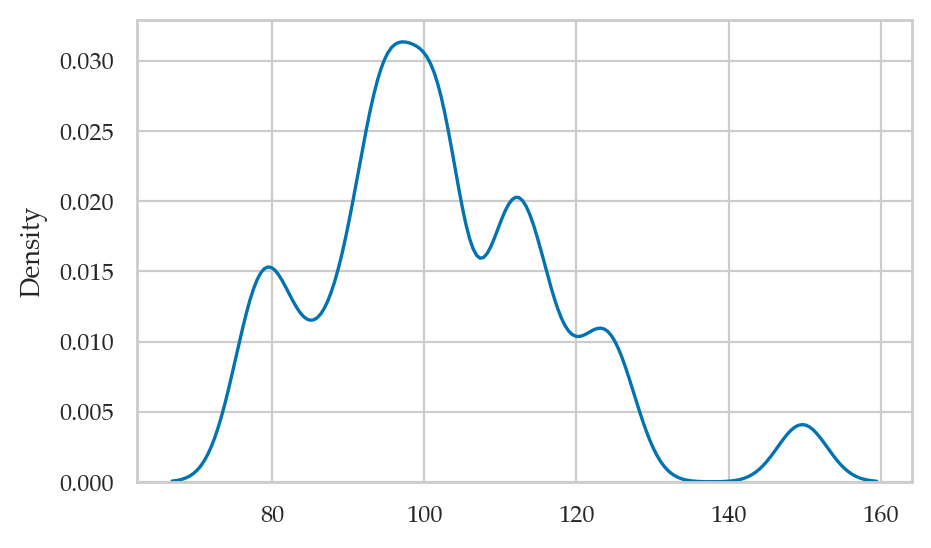

In [16]:
# data gen 2
from scipy.stats import norm

n = 30
np.random.seed(50)
iqs = norm(loc=100, scale=15).rvs(n)
iqs
sns.kdeplot(iqs, bw_adjust=0.4)
np.mean(iqs), np.std(iqs)

## Example 1: estimating the probability of a biased coin

In [17]:
#######################################################
from scipy.stats import uniform
from scipy.stats import bernoulli

# Sample of coin tosses observations (1=heads 0=tails)
# We assume they come from a Bernoulli distribution
tosses = [1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,1,1,1,1,0,0,0,
          1,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,1,
          1,1,0,1,1,0]

# 1. Define a grid of possible `pi` values
ngrid1 = 101             # number of points in the grid
pis = np.linspace(0, 1, ngrid1) # [0, 0.01, ..., 1.0]
dgrid1 = (1-0) / ngrid1   # grid spacing

# 2. Define a flat prior distribution
prior1 = uniform(0,1).pdf(pis)

# 3. Compute the likelihood of `tosses` for all `pis`
likelihood = np.ones(ngrid1)
for toss in tosses:
    likelihood_toss = bernoulli(p=pis).pmf(toss)
    likelihood = likelihood * likelihood_toss
# ALT.
# np.prod(bernoulli(p=pis[:,np.newaxis]).pmf(tosses), axis=1)

# 4. Calculate the posterior distribution
numerator = likelihood * prior1
posterior1 = numerator / np.sum(numerator) / dgrid1

In [18]:
# normalization checks (CUT ME)
np.sum(prior1), np.sum(posterior1), myint(pis, prior1), myint(pis, posterior1)

(101.0, 100.99999999999997, 1.01, 1.0099999999999998)

### Visualize the posterior

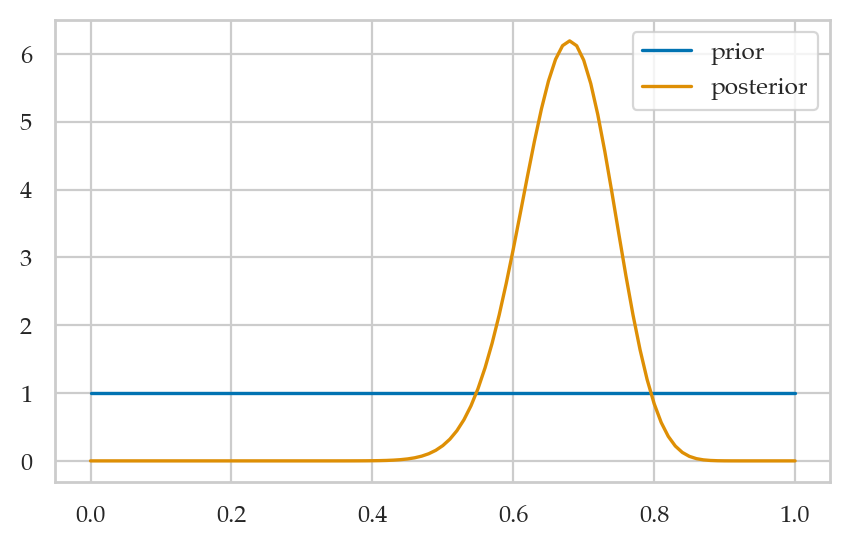

In [19]:
sns.lineplot(x=pis, y=prior1, label='prior')
sns.lineplot(x=pis, y=posterior1, label='posterior');

### Summarize the posterior

#### Posterior mean

In [20]:
np.mean(pis * posterior1 * dgrid1)

0.006664127951256662

#### Posterior median

In [21]:
cumsum1 = np.cumsum(posterior1 * dgrid1) 
pis[cumsum1.searchsorted(0.5)]

0.68

#### Posterior mode

In [22]:
pis[np.argmax(posterior1)]

0.68

### Predictions

In [23]:
from scipy.stats import bernoulli

np.random.seed(43)
pred_tosses = []
for i in range(20):
    pi_post = np.random.choice(pis, p=posterior1*dgrid1)
    pred_toss = bernoulli(p=pi_post).rvs(1)[0]
    pred_tosses.append(pred_toss)
pred_tosses

[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1]

## Example 2: estimating the IQ score

In [24]:
from scipy.stats import norm

#######################################################

# Sample of IQ observations
iqs = [ 76.6,  99.5,  90.7,  78. , 121.2,  92.8, 88.3,
       116.1,  80.8, 80.1, 101.9, 112.9, 110.5,   95,
        85. , 124., 149.7, 114.8, 101.9, 111.1,  94.1,
       102.2,  93.8,  97.6, 102.1, 104.3,  95.8, 125.7,
        97.8, 110.4]

sigma = 15  # known population standard deviation


# 1. Define a grid of possible means
ngrid2 = 1001               # number of points in the grid
mus = np.linspace(80, 120, ngrid2)
dgrid2 = (120-80) /  ngrid2  # grid spacing

# 2. Define the prior = normal centered at 100 with std 30
mu0 = 100
sigma0 = 30
prior2 = norm(loc=mu0, scale=sigma0).pdf(mus)

# 3. Compute the likelihood of the data for all `mus`
likelihood = np.ones(ngrid2)
for iq in iqs:
    likelihood_iq = norm(loc=mus, scale=sigma).pdf(iq)
    likelihood = likelihood * likelihood_iq
# ALT.
# likelihood = np.prod(norm(loc=mus[:,np.newaxis], scale=sigma).pdf(iqs), axis=1))

# 4. Calculate the posterior distribution
numerator = likelihood * prior2
posterior2 = numerator / np.sum(numerator) / dgrid2

In [25]:
# normalization checks of prior and posterior
np.sum(prior2), np.sum(posterior2), myint(mus, prior2), myint(mus, posterior2)

(12.386019811983466,
 25.024999999999995,
 0.4954407924794161,
 1.0010000000001562)

### Visualize the posterior

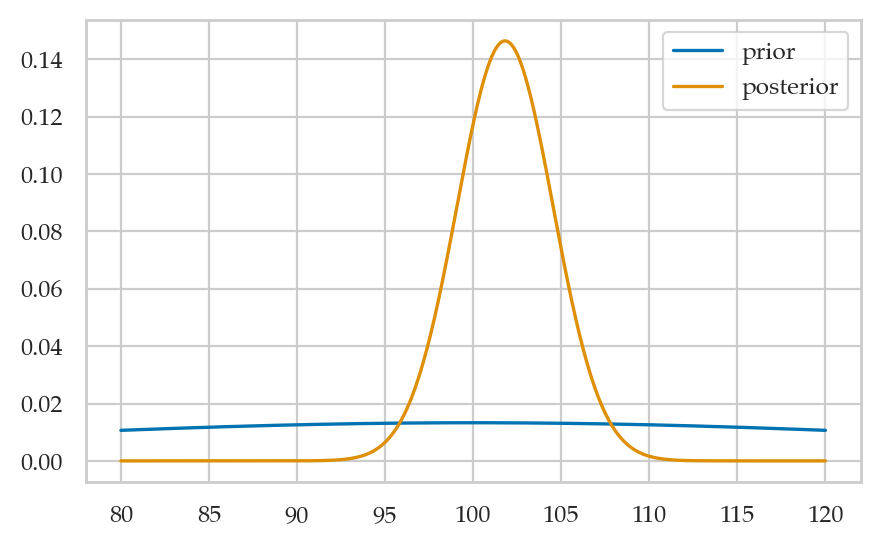

In [26]:
sns.lineplot(x=mus, y=prior2, label='prior')
sns.lineplot(x=mus, y=posterior2, label='posterior');

### Summarize the posterior

#### Posterior mean

In [27]:
np.sum(mus * posterior2 * dgrid2)

101.80826446258413

#### Posterior median

In [28]:
cumsum2 = np.cumsum(posterior2 * dgrid2)
mus[cumsum2.searchsorted(0.5)]

101.8

#### Posterior mode

In [29]:
mus[np.argmax(posterior2)]

101.8

### Predictions

In [30]:
np.random.seed(43)

sigma = 15  # known population standard deviation

pred_iqs = []
for i in range(10):
    mu_post = np.random.choice(mus, p=posterior2*dgrid2)
    pred_iq = norm(loc=mu_post, scale=sigma).rvs(1)[0]
    pred_iqs.append(pred_iq)
pred_iqs

[83.63670562899156,
 104.30779433005354,
 106.69141315621167,
 115.25148552252136,
 86.5861308561721,
 126.49101566601618,
 92.9679979691743,
 79.87256003503298,
 101.04324394721351,
 110.0720956811958]

## Explanations

### Grid approximation details

### Choosing priors

In [31]:
from ministats.hpdi import hpdi_from_grid

def get_post_mean_stats(sample, sigma=15, prior_rv=None, ngrid=1001, xlims=[70,130],
                       stats=["mean", "median", "mode", "ci90"]):
    mus = np.linspace(*xlims, ngrid)
    dgrid = (xlims[1]-xlims[0]) /  ngrid
    prior = prior_rv.pdf(mus)
    likelihoodsM = norm(loc=mus[:,np.newaxis], scale=sigma).pdf(sample)
    likelihood = np.prod(likelihoodsM, axis=1)
    numerator = likelihood * prior
    posterior = numerator / np.sum(numerator) / dgrid

    # compute stats
    results = {}
    if "mean" in stats:
        post_mean = np.sum(mus * posterior * dgrid)
        results["mean"] = post_mean
    if "median" in stats:
        cumsum = np.cumsum(posterior * dgrid)
        post_median = mus[cumsum.searchsorted(0.5)]
        results["median"] = post_median
    if "mode" in stats:
        post_mode = mus[np.argmax(posterior)]
        results["mode"] = post_mode
    if "ci90" in stats:
        ci90 = hpdi_from_grid(mus, posterior*dgrid, hdi_prob=0.9)
        results["ci90"] = ci90
    return results

In [32]:
# frequentist summary
from ministats import ci_mean
np.mean(iqs), ci_mean(iqs, alpha=0.1)

(101.82333333333334, [96.83429390645762, 106.81237276020906])

In [33]:
get_post_mean_stats(iqs, prior_rv=norm(loc=100, scale=50))

{'mean': 101.81787969425056,
 'median': 101.8,
 'mode': 101.8,
 'ci90': [97.3, 106.3]}

In [34]:
get_post_mean_stats(iqs, prior_rv=norm(loc=100, scale=30))

{'mean': 101.80826446280992,
 'median': 101.8,
 'mode': 101.8,
 'ci90': [97.48, 106.47999999999999]}

In [35]:
get_post_mean_stats(iqs, prior_rv=norm(loc=100, scale=20))

{'mean': 101.78977505112476,
 'median': 101.8,
 'mode': 101.8,
 'ci90': [97.18, 106.12]}

In [36]:
get_post_mean_stats(iqs, prior_rv=norm(loc=100, scale=10))

{'mean': 101.69612403100776,
 'median': 101.68,
 'mode': 101.68,
 'ci90': [97.24, 105.94]}

In [37]:
get_post_mean_stats(iqs, prior_rv=norm(loc=100, scale=1))

{'mean': 100.21450980392156,
 'median': 100.24,
 'mode': 100.24,
 'ci90': [98.62, 101.74]}

## Discussion

### Bayesian decision theory

### Comparing Bayesian and frequentist approaches to statistical inference

### Strengths and weaknesses of Bayesian approach

## Exercises

### Exercise: Bayes rule for diagnostic test

A group of researchers has designed a new
inexpensive and painless test for detecting lung cancer. The test is
intended to be an initial screening test for the population in
general. A positive result (presence of lung cancer) from the test
would be followed up immediately with medication, surgery or more
extensive and expensive test. The researchers know from their
studies the following facts:

-   Test gives a positive result in $98\%$ of the time when the test
    subject has lung cancer.
-   Test gives a negative result in $96\%$ of the time when the
    test subject does not have lung cancer.
-   In general population approximately one person in 1000 has lung
    cancer.


**a)** The researchers are happy with these preliminary results (about
$97\%$ success rate), and wish to get the test to market as soon as
possible. How would you advise them? Base your answer on Bayes' rule
computations.

HINT: Relatively high false negative (cancer doesn't get
detected) or high false positive (unnecessarily administer
medication) rates are typically bad and undesirable in tests.




Here are some probability values that can help you figure
out if you copied the right conditional probabilities from the
question.

-   P(Test gives positive \| Subject does not have lung cancer) =
    $4\%$
-   P(Test gives positive **and** Subject has lung cancer) =
    $0.098\%$ this is also referred to as the **joint probability**
    of *test being positive* and the *subject having lung cancer*.


* Is p(has cancer|test result is positive) computed using Bayes' formula
(or its complement p(does not have cancer|test result is positive))?
* Is the result p(has cancer|test result is positive)=**...** (or p(does not have cancer|test result
is positive)=**...**)
* Is the result motivated with something like



See here for viz https://sophieehill.shinyapps.io/base-rate-viz/

In [38]:
# In general population approximately one person in 1000 has lung cancer.
prev = 0.001

# Test gives a positive result in 98% of the time when the test subject has lung cancer.
# Sensitivity: the ability of a test to correctly identify patients with a disease.
pPgC = sens = 0.98


# Test gives a negative result in 96% of the time when the test subject does not have lung cancer.
# Specificity: the ability of a test to correctly identify people without the disease.
pNgNC = spec = 0.96

In [39]:
# P(Test gives positive | Subject does not have lung cancer) = 4%
pPgNC = (1-spec)
pPgNC

0.040000000000000036

In [40]:
# P(Test gives positive and Subject has lung cancer) = 0.098%
pPC = sens*prev
pPC

0.00098

In [41]:
pP = prev*sens + (1-prev)*(1-spec)
pP

0.04094000000000004

In [42]:
# Pr(C|P) = Pr(C and P) / Pr(P) 
pCgP      = pPC         / pP
pCgP

0.02393746946751341

In [43]:
# ALT
# Pr(C|P) = Pr(P|C)Pr(C) / Pr(P)
pCgP      = pPgC*prev / pP
pCgP

0.02393746946751341

In [44]:
1 - pCgP

0.9760625305324866


Given the high rate of false-positives 97.6%, I would advise the researchers not to proceed with the screening to the whole population. There will be way too many people scared for nothing.
The test can be used for patients who are suspected they might have lung cancer. In such a sub-population the prevalence would be higher and thus the false-positive rate would decrease.
I would possibly use a visualization tool to illustrate the [base rate fallacy](https://sophieehill.shinyapps.io/base-rate-viz/) problem.


### Exercise: algae

see [assignment2](./explorations/BDA_course/assignment2/assignment2.qmd) from the BDA course

## Links